# CorEx (Correlation Explanation) for Topic Modeling
- [CorEx reference](https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb)
- unsupervised and semi-supervised topic modeling

In [ ]:
# # Install CorEx 
# !pip install corextopic
# !pip install networkx

In [17]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Functions

In [20]:
def topic_modeling(num_topics, column_labels, seed_num, doc_word_matrix,):
    # train model
    topic_model = ct.Corex(n_hidden=num_topics, words=column_labels, seed=seed_num)
    topic_model.fit(doc_word_matrix, words=column_labels)
    
    # the measure which CorEx maximizes when constructing the topic model; reported in nats
    print(f'Overall Total Correlation: {topic_model.tc.round(3)}')
    
    # print all topics from CorEx topic model
    topics = topic_model.get_topics()
    for n, topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
    return topic_model

In [21]:
def topic_tc_chart(topic_model):
    plt.figure(figsize=(10,5))
    x_positions = range(topic_model.tcs.shape[0])  # number of topics
    bar_labels = range(topic_model.tcs.shape[0]) 
    plt.bar(x_positions, topic_model.tcs, width=0.5)  
    plt.xticks(x_positions, bar_labels)
    plt.xlabel('Topic', fontsize=16)
    plt.ylabel('Total Correlation (nats)', fontsize=16);

## Load data

In [4]:
# will take 1-2 minutes to load pickle
df_spacy_debt = pd.read_pickle('df_clean_spacy_debt.pkl')
df_spacy_debt.head()

## CountVectorizer
- the topic model assumes input is in the form of a doc-word matrix (rows are documents; columns are binary counts)
- vectorize data (unigrams and bi-grams) and take top 20,000 grams
- note: CorEx topic model uses **binary count vectors** as input

In [10]:
cv = CountVectorizer(max_features=20000,
                     ngram_range=(1,2),
                     min_df=3, 
                     max_df=0.8,
                     binary=True)

doc_word = cv.fit_transform(df_spacy_debt['clean_spacy_doc2'])
doc_word.shape # n_docs x m_words

(18156, 20000)

In [11]:
# get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(cv.get_feature_names()))

## CorEx Topic Modeling

In [22]:
topic_model = topic_modeling(20, words, 52, doc_word)
topic_model

Overall Total Correlation: 53.766
0: shall,require,evidence,sec,defamation,title,obligation,report company,claim dispute,mark find
1: standard information,sure quickly,present record,petition sure,right petition,figure display,precisely balance,credit figure,demand accordance,wrong sure
2: federal,follow,law,creditor,party,provide follow,license,fdcpa,include,allege
3: pay,payment,month,go,year,get,time,money,want,later
4: fee,interest,charge,statement,email,offer,issue,balance,customer,able
5: provide,validation,request,proof,signature,copy,verification,contract,validate,debt
6: speak,ask,say,representative,contact,know,hang,explain,supervisor,give
7: file,complaint,claim,action,notice,date,respond,day,office,agency
8: act,fair,fair debt,reporting act,practices,practices act,collection practices,credit reporting,fair credit,reporting
9: section,accordance,item,record,demand,cause,subsection,civil,fully,collection debt
10: credit report,credit,report,credit bureau,bureau,report credit,

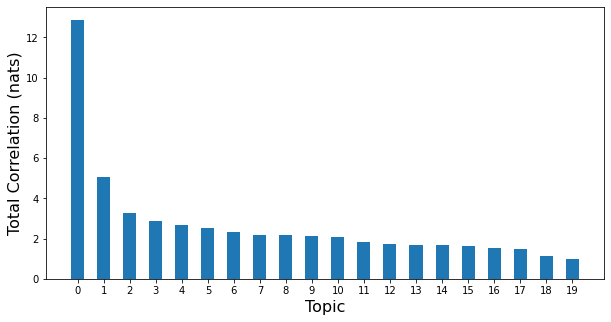

In [23]:
topic_tc_chart(topic_model)